# **TikTok**


# **Random Forest and XGBoost**

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion". With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

*This Notebook has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps







# **PACE stages**


## **PACE: Plan**

Consider the following questions:

**1. What are you being asked to do?**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.
**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim


**2. What are the ethical implications of building the model?**

In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

**3. How would you proceed?**

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Task 1. Imports and data loading**



In [71]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, classification_report,RocCurveDisplay,precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path_main = '/content/drive/MyDrive/Data Analytics/Main Projects/TikTok project/tiktok_dataset.csv'

df = pd.read_csv(file_path_main)

## **PACE: Analyze**


### **Task 2: Examine data, summary info, and descriptive stats**

Inspecting the first five rows of the dataframe:

In [5]:
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Getting the number of rows and columns in the dataset:

In [6]:
df.shape

(19382, 12)

Getting the data types of the columns:

In [7]:
df.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Getting basic information about the dataset:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generating basic descriptive statistics about the dataset:

In [9]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Checking for and handling missing values:

In [10]:
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [11]:
df = df.dropna(axis=0)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


Checking for and handling duplicates:

In [13]:
df.duplicated().sum()

0

Checking for and handle outliers:

Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

Checking class balance.

In [14]:
df["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

## **PACE: Construct**

### **Task 3: Feature engineering**

Extracting the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model:

In [15]:
df["text_len"] = df["video_transcription_text"].str.len()

Calculate the average text_length for claims and opinions:

In [16]:
df.groupby(["claim_status"])["text_len"].mean()

claim_status
claim      95.376978
opinion    82.722562
Name: text_len, dtype: float64

Visualizing the distribution of `text_length` for claims and opinions:

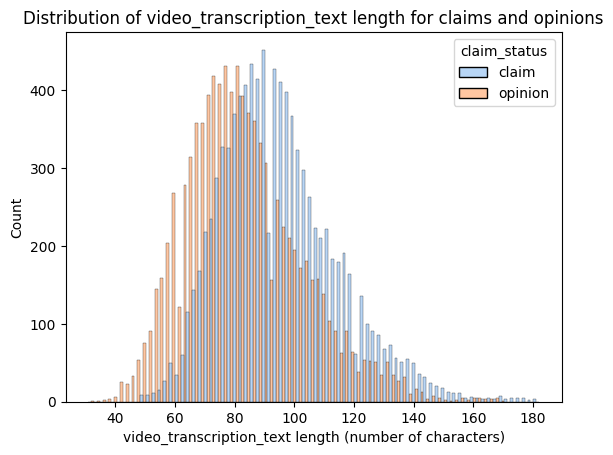

In [17]:
sns.histplot(data=df, stat="count", multiple="dodge", x="text_len",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Encode target and catgorical variables.

In [18]:
df_1 = df.copy()

df_1.drop(columns=["#","video_id"],inplace=True)

df_1["claim_status"] = df_1["claim_status"].replace({"claim":1,"opinion":0})

df_1 = pd.get_dummies(df_1,columns=["verified_status","author_ban_status"],drop_first=True)

df_1.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_len,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


### **Task 4: Split the data**

Assigning target variable:

In [19]:
y = df_1["claim_status"]

Isolating the features:

In [20]:
X = df_1.drop(columns=["claim_status"])
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_len,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


#### **Task 5: Create train/validate/test sets**

Splitting data into training and testing sets, 80/20:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Splitting the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets:

In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=0)


Confirming that the dimensions of the training, validation, and testing sets are in alignment:

In [23]:
X_tr.shape, X_val.shape, X_test.shape, y_tr.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

### **Task 6. Tokenize text column**

Setting up a `CountVectorizer` object, which converts a collection of text to a matrix of token count:

In [24]:
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Extract numerical features from `video_transcription_text` in the training set and concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_tr_final`)

**Notes**:

- Use `fit_transform()` only with the training data.

- Use `reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`

In [25]:
count_tr_data = count_vec.fit_transform(X_tr['video_transcription_text']).toarray()
count_tr_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
count_tr_df = pd.DataFrame(data=count_tr_data,columns=count_vec.get_feature_names_out())
X_tr_final = pd.concat([X_tr.drop(columns=['video_transcription_text']).reset_index(drop=True), count_tr_df], axis=1)
X_tr_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_len,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Doing the same with `X_val` and `X_test`:

Here, only `transform()`.

In [27]:
count_val_data = count_vec.transform(X_val['video_transcription_text']).toarray()
count_val_df = pd.DataFrame(data=count_val_data,columns=count_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), count_val_df], axis=1)

In [28]:
count_test_data = count_vec.transform(X_test['video_transcription_text']).toarray()
count_test_df = pd.DataFrame(data=count_test_data,columns=count_vec.get_feature_names_out())
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True), count_test_df], axis=1)

### **Task 7. Build models**


### **Building a random forest model**

Fitting a random forest model to the training set and using cross-validation to tune the hyperparameters and select the model that performs best on recall:

In [29]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

#rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [30]:
%%time
#rf_cv.fit(X_tr_final, y_tr)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


In [31]:
def write_pickle(model_object, save_name:str):
  from google.colab import files
  with open(save_name , 'wb') as to_write:
    pickle.dump(model_object, to_write)
  files.download(save_name)

In [32]:
def read_pickle(path, saved_model_name:str):
  with open(path + saved_model_name, 'rb') as to_read:
    model = pickle.load(to_read)
    return model

In [33]:
#write_pickle(rf_cv,"rf_cv_tiktok")

In [34]:
path_ = '/content/drive/MyDrive/Data Analytics/Main Projects/TikTok project/Phase 6: Random Forest and XGB models/'
saved_model_ = 'rf_cv_tiktok'
rf_cv = read_pickle(path_,saved_model_)

Examining best recall score:

In [35]:
rf_cv.best_score_

0.9948228253467271

Examining best parameters:

In [36]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Getting all the results from the CV and put them in a df:

In [37]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [38]:
results_rf_tr = make_results("Random Forest CV",rf_cv,"recall")
results_rf_tr

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.999481,0.994823,0.997145,0.997118


**Question:** How well is the model performing? Consider average recall score and precision score.

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Building an XGBoost model**

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
#xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')


In [ ]:
%%time
#xgb_cv.fit(X_tr_final,y_tr)

CPU times: user 2min 42s, sys: 1.55 s, total: 2min 43s
Wall time: 1min 48s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'recall', 'f1', 'precision', 'accuracy'})

In [ ]:
#write_pickle(xgb_cv,"xgb_cv_tiktok")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
path_ = '/content/drive/MyDrive/Data Analytics/Main Projects/TikTok project/Phase 6: Random Forest and XGB models/'
saved_model_ = 'xgb_cv_tiktok'
xgb_cv = read_pickle(path_,saved_model_)

In [40]:
xgb_cv.best_score_

0.9898176171763818

In [41]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [42]:
results_xgb_tr = make_results("XGBoost CV",xgb_cv,"recall")
results_xgb_tr

,model,precision,recall,F1,accuracy
0,XGBoost CV,0.998954,0.989818,0.994363,0.994323


**Question:** How well does the model perform? Consider recall score and precision score.

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.


## **PACE: Execute**


### **Task 8. Evaluate model on validation data**

**Evaluating models against validation criteria.**

#### **Random forest**

Displaying the predictions on the encoded validation set.

In [43]:
y_pred_val_rf = rf_cv.best_estimator_.predict(X_val_final)
y_pred_val_rf

array([1, 0, 1, ..., 1, 1, 1])

Creating a confusion matrix to visualize the results of the classification model.

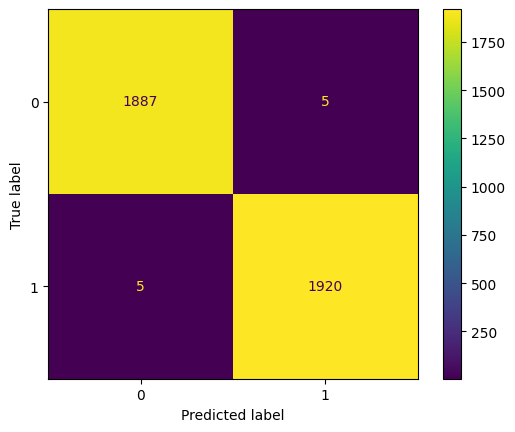

In [44]:
log_cm = confusion_matrix(y_val, y_pred_val_rf)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.show()

**Notes**:

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

Creating a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model:

In [45]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [46]:
rf_val_res = get_test_scores("Random Forest val",y_pred_val_rf,y_val)
rf_val_res

,model,precision,recall,F1,accuracy
0,Random Forest val,0.997403,0.997403,0.997403,0.99738


Visualizing the ROC Curve:

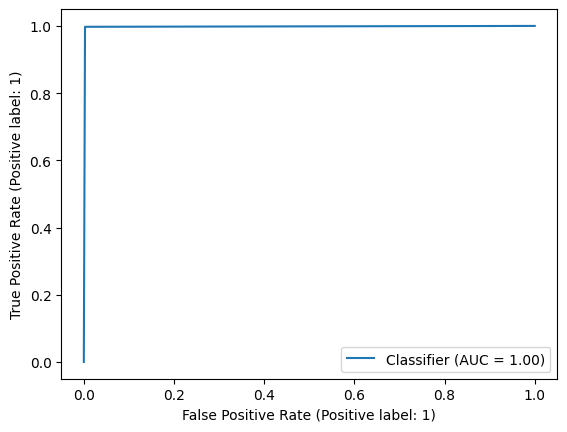

In [60]:
RocCurveDisplay.from_predictions(y_val,y_pred_val_rf)

Visualizing the precision-recall-curve:

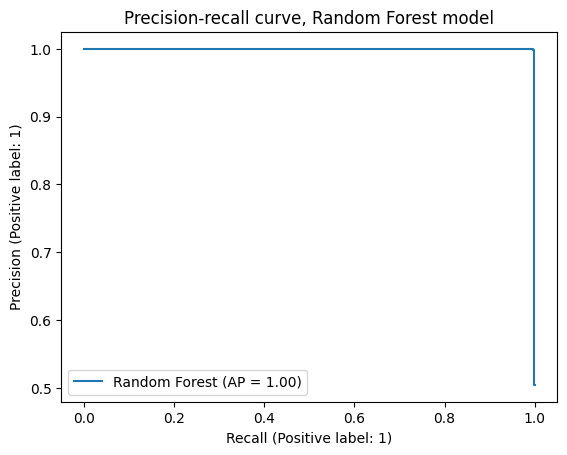

In [63]:
display = PrecisionRecallDisplay.from_estimator(
    rf_cv.best_estimator_, X_val_final, y_val, name='Random Forest'
    )
plt.title('Precision-recall curve, Random Forest model');

**Question:** What does the classification report show? What does the confusion matrix indicate?

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

In [47]:
y_pred_val_xgv = xgb_cv.best_estimator_.predict(X_val_final)
y_pred_val_xgv

array([1, 0, 1, ..., 1, 1, 1])

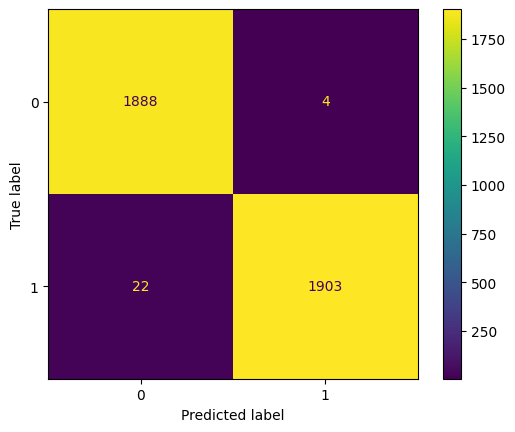

In [48]:
log_cm = confusion_matrix(y_val, y_pred_val_xgv)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.show()

In [49]:
xgb_val_res = get_test_scores("XGB val",y_pred_val_xgv,y_val)
xgb_val_res

,model,precision,recall,F1,accuracy
0,XGB val,0.997902,0.988571,0.993215,0.993188


Visualizing the ROC Curve:

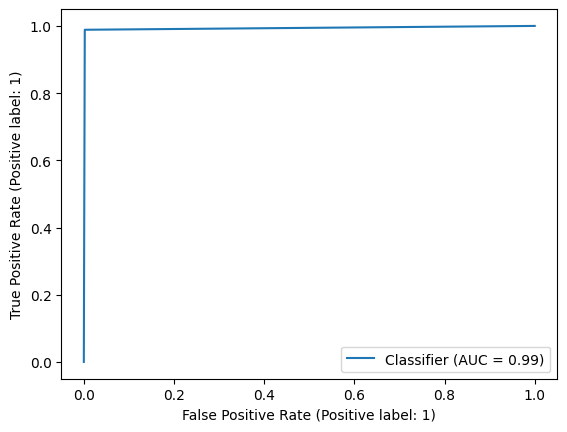

In [69]:
RocCurveDisplay.from_predictions(y_val,y_pred_val_xgv)

Visualizing the precision-recall-curve:

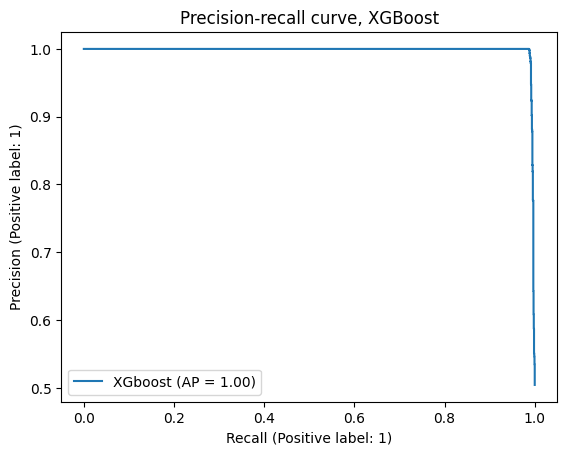

In [75]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_val_final, y_val, name='XGboost'
    )
plt.title('Precision-recall curve, XGBoost');

**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

In [ ]:
final_res = pd.concat([xgb_val_res, rf_val_res, results_xgb_tr, results_rf_tr])
final_res

,model,precision,recall,F1,accuracy
0,XGB val,0.997902,0.988571,0.993215,0.993188
0,Random Forest val,0.997403,0.997403,0.997403,0.997380
0,XGBoost CV,0.998954,0.989818,0.994363,0.994323
0,Random Forest CV,0.999481,0.994823,0.997145,0.997118


The model with the highest recall is the Random Forest, with a value of 0.997403, so it would be the "champion" in terms of recall in this comparison.

### **Using champion model to predict on test data**

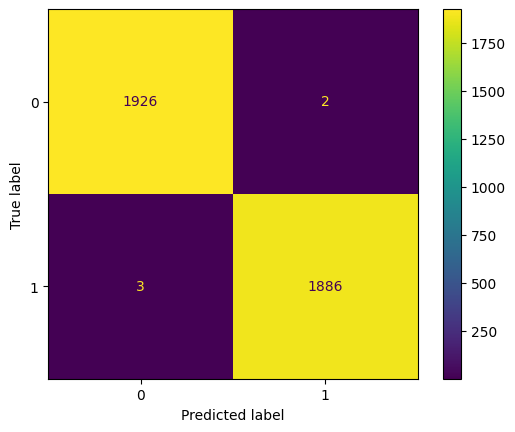

In [50]:
y_pred_test = rf_cv.best_estimator_.predict(X_test_final)
log_cm = confusion_matrix(y_test, y_pred_test)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.show()

#### **Feature importances of champion model**


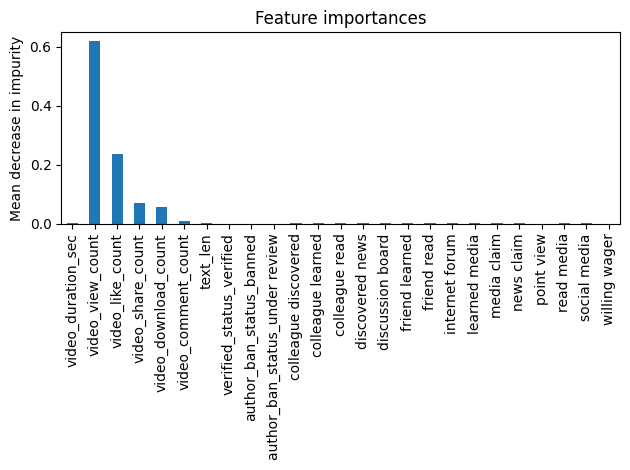

In [73]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_tr_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Question:** Describe your most predictive features. Were your results surprising?

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

### **Task 9. Conclusion**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Consider the following questions:





1. *Would you recommend using this model? Why or why not?*
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. *What was your model doing? Can you explain how it was making predictions?*
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. *Are there new features that you can engineer that might improve model performance?*
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. *What features would you want to have that would likely improve the performance of your model?*
The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.